In [1]:
import kagglehub
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random
import os
import imghdr
import math
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset

/tmp/ipython-input-3424010906.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [4]:
files_in_directory = os.listdir(path)

print(f"Files in directory '{path}':")
for file_name in files_in_directory:
    print(file_name)

Files in directory '/kaggle/input/dog-and-cat-classification-dataset':
PetImages


In [5]:
main_dir = path + '/PetImages'
dog_dir = main_dir+'/Dog'
cat_dir = main_dir+'/Cat'

In [6]:
def plot_images_from_directory(directory_path, class_animal):
  image_files = os.listdir(directory_path)

  selected_images = random.sample(image_files, 9)

  fig, ax = plt.subplots(3, 3, figsize=(15,10))

  ax = ax.flatten()

  for idx,image_files in enumerate(selected_images):
    img_path = os.path.join(directory_path, image_files)
    img = Image.open(img_path)
    ax[idx].imshow(img)
    ax[idx].set_title(class_animal)
    ax[idx].axis('off')

  plt.tight_layout()
  plt.show()

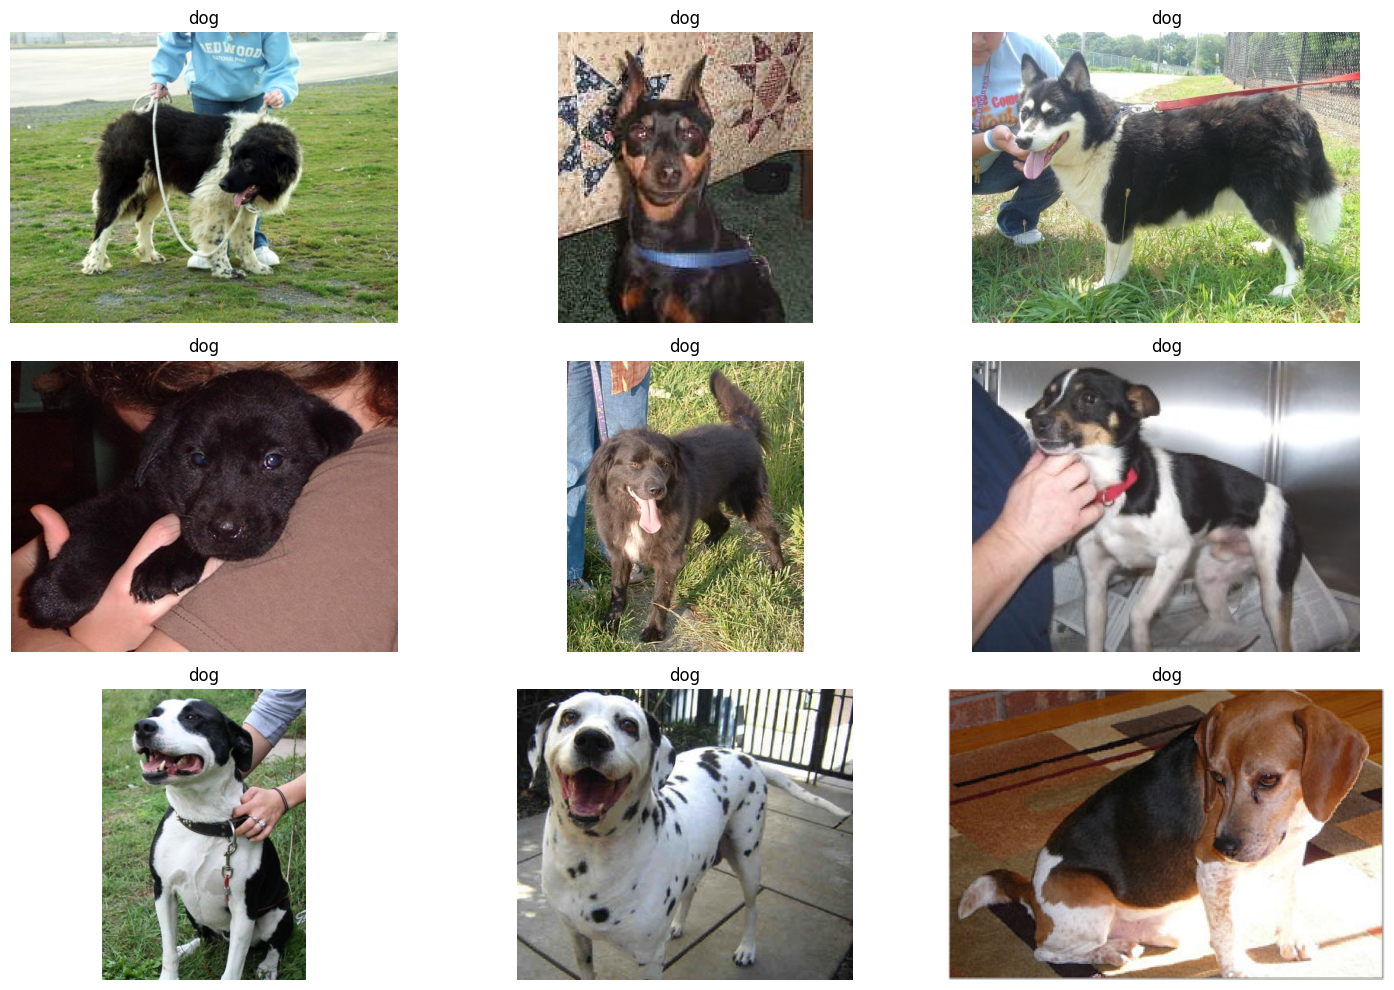

In [7]:
plot_images_from_directory(dog_dir, 'dog')

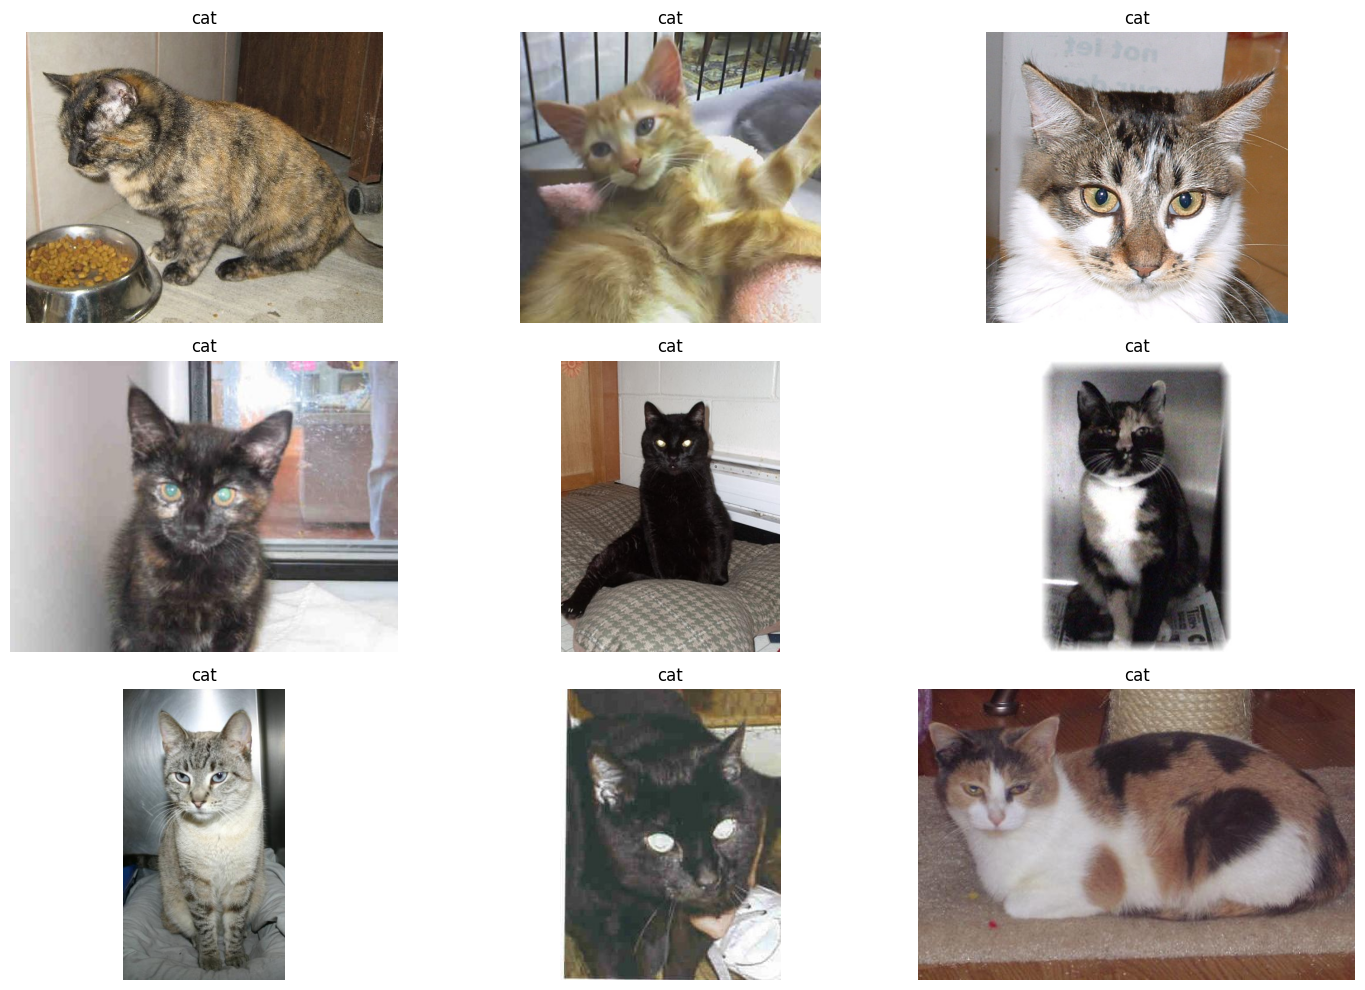

In [8]:
plot_images_from_directory(cat_dir, 'cat')

In [9]:
cat_imgs = os.listdir(cat_dir)
dog_imgs = os.listdir(dog_dir)

len(cat_imgs), len(dog_imgs)

(12499, 12499)

In [10]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp', 'gif']
# some image name may contain above extension, but in actual they are not above extension wale image, hence we are removing those files


cat_files_remove_counter = 0
for img in cat_imgs:

  file_path = os.path.join(cat_dir, img)

  try:
    file_type = imghdr.what(file_path)
    if file_type not in image_exts:
      cat_imgs.remove(img)
      cat_files_remove_counter += 1
      print("cat files removed till now : ", cat_files_remove_counter)

  except Exception as e:
    print(f'Issue with file {file_path}, error : {e}')
    cat_imgs.remove(img)
    cat_files_remove_counter += 1
    print("cat files removed till now : ", cat_files_remove_counter)

print('*'*100)


dog_file_remove_counter = 0
for img in dog_imgs:

  file_path = os.path.join(cat_dir, img)

  try:
    file_type = imghdr.what(file_path)
    if file_type not in image_exts:
      dog_imgs.remove(img)
      dog_file_remove_counter += 1
      print("dogs files removed till now : ", dog_file_remove_counter)

  except Exception as e:
    print(f'Issue with file {file_path}, error : {e}')
    dog_imgs.remove(img)
    dog_file_remove_counter += 1
    print("dogs files removed till now : ", dog_file_remove_counter)

cat files removed till now :  1
cat files removed till now :  2
cat files removed till now :  3
cat files removed till now :  4
cat files removed till now :  5
cat files removed till now :  6
cat files removed till now :  7
cat files removed till now :  8
cat files removed till now :  9
cat files removed till now :  10
cat files removed till now :  11
cat files removed till now :  12
cat files removed till now :  13
cat files removed till now :  14
cat files removed till now :  15
****************************************************************************************************
dogs files removed till now :  1
dogs files removed till now :  2
dogs files removed till now :  3
dogs files removed till now :  4
dogs files removed till now :  5
dogs files removed till now :  6
dogs files removed till now :  7
dogs files removed till now :  8
dogs files removed till now :  9
dogs files removed till now :  10
dogs files removed till now :  11
Issue with file /kaggle/input/dog-and-cat-classi

In [11]:
# make absolute paths

dog_imgs = [os.path.join(dog_dir,i) for i in dog_imgs]
cat_imgs = [os.path.join(cat_dir,i) for i in cat_imgs]

In [12]:
np.array(Image.open(dog_imgs[9])).max()

np.uint8(255)

In [13]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)), # Resize the PIL Image first
        transforms.ToTensor(),        # Convert to Tensor and scale to [0,1]
        transforms.RandomHorizontalFlip(0.4),
        transforms.RandomVerticalFlip(0.4)
    ]
)

In [14]:
class CustomDataset(Dataset):

  def __init__(self, dog_img_list, cat_img_list, transform = None):

    self.dog = dog_img_list
    self.dog_label = [1]*len(self.dog)

    self.cat = cat_img_list
    self.cat_label = [0]*len(self.cat)

    self.transform = transform

    self.all_img = self.dog + self.cat
    self.all_label = self.dog_label + self.cat_label


  def __len__(self):
    return len(self.all_img)

  def __getitem__(self, idx):

    img_path = self.all_img[idx]
    img = Image.open(img_path).convert('RGB') # Open as PIL Image and ensure it's RGB

    if self.transform:
      img = self.transform(img)

    return img, torch.tensor(self.all_label[idx], dtype=torch.long)

In [15]:
total_dog_img = len(dog_imgs)
total_cat_img = len(cat_imgs)

train_dog_data = dog_imgs[ : math.ceil(total_dog_img*0.8)]
test_dog_data = dog_imgs[len(train_dog_data) : ]

train_cat_data = cat_imgs[ : math.ceil(total_cat_img*0.8)]
test_cat_data = cat_imgs[len(train_cat_data) : ]

In [16]:
len(train_dog_data) + len(test_dog_data) == total_dog_img, len(train_cat_data) + len(test_cat_data) == total_cat_img

(True, True)

In [17]:
traindataset = CustomDataset(train_dog_data, train_cat_data, transform=transform)
testdataset = CustomDataset(test_dog_data, test_cat_data, transform=transform)

In [18]:
traindataloader = DataLoader(traindataset, batch_size=100, shuffle=True, pin_memory=True, num_workers=2)

In [19]:
# # visualizing through the traindataloader

# fig, ax = plt.subplots(2,2)
# ax = ax.ravel()

# for i in range(4):
#   for img, cls in traindataloader:
#       ax[i].imshow(img[0].T)
#       ax[i].axis('off')
#       ax[i].set_title(label=['dog' if cls == 1 else 'cat'][0])
#       break

# plt.legend()
# plt.show()

In [20]:
class myCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(3, 3),

        nn.Conv2d(32, 64, 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(3,3)
      )

    with torch.no_grad():
      dummy = self.features(torch.zeros(1, 3, 256,256))
    input_size = dummy.flatten().shape[0]

    print(input_size)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(64, 1)
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

In [21]:
model = myCNN()

model = model.to(device)

loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

epochs = 20

for epoch in range(epochs):
  epoch_loss = []
  for img, label in traindataloader:

    img, label = img.to(device), label.to(device)

    prediction = model(img)

    # Convert label to float and reshape to match prediction shape [batch_size, 1]
    loss = loss_function(prediction, label.float().view(-1, 1))

    epoch_loss.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  print(f'at epoch {epoch} loss is {np.mean(np.array(epoch_loss))}')

46656


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 0 loss is 0.6412273496389389


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 1 loss is 0.5597812972962857


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 2 loss is 0.5165272019803524


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 3 loss is 0.48434875592589377


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 4 loss is 0.4649883830547333


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 5 loss is 0.44074836358428


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 6 loss is 0.41671492397785187


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 7 loss is 0.39658001080155375


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 8 loss is 0.36911059051752093


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 9 loss is 0.35470300912857056


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 10 loss is 0.3318136847019196


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 11 loss is 0.3185371395945549


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 12 loss is 0.2967520412057638


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 13 loss is 0.28679322332143786


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 14 loss is 0.26170802004635335


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 15 loss is 0.25293936565518377


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 16 loss is 0.23663304686546327


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 17 loss is 0.22510959964245558


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 18 loss is 0.20982917562127112


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


at epoch 19 loss is 0.19745771117508412


In [22]:
testdataloader = DataLoader(testdataset, batch_size=100, shuffle=False, pin_memory=True, num_workers=2)

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [94]:
model.eval()

scores = []
confusion_matrix_result = np.zeros((2,2))
with torch.no_grad():
  for img, label in testdataloader:
    img = img.to(device)
    predictions = model(img)
    predictions = torch.sigmoid(predictions)
    predictions = np.where(predictions.cpu().numpy() > 0.5, 1, 0)
    score = accuracy_score(label.cpu(), predictions)
    scores.append(score)

    mtx = confusion_matrix(label, predictions)
    confusion_matrix_result = confusion_matrix_result + mtx

In [95]:
np.mean(np.array(scores))

np.float64(0.792608695652174)

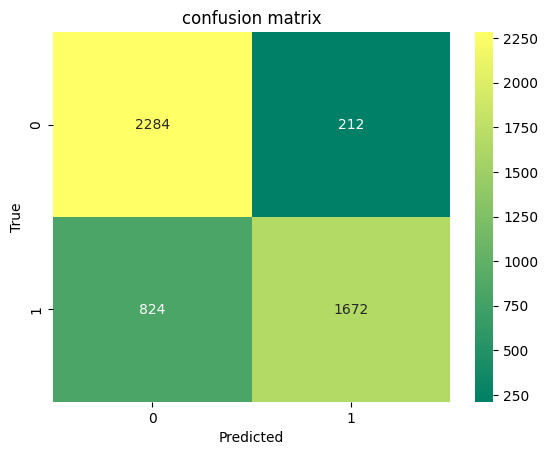

In [96]:
import seaborn as sns

sns.heatmap(confusion_matrix_result.astype(int), annot=True, cmap="summer", fmt='d')
plt.title('confusion matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [120]:
def make_prediction(image_path):
  img = Image.open('/content/images.jpg').resize((256,256)).convert('RGB')
  img = transform(img)
  img = img.to(device)
  with torch.no_grad():
    label = 'Dog' if torch.sigmoid(model(img.unsqueeze(0))) > 0.5 else 'Cat'
  # manually apply sigmoid, as we don't have sigmoid in our CNN
  # unsqueeze to add one more dim, as our model want 4d input (batch me prediction)

  plt.imshow(img.cpu().T)
  plt.title(f'predicted -> {label}')
  plt.show()

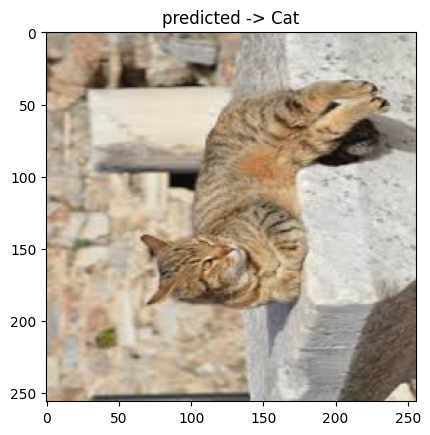

In [121]:
make_prediction('klsf')

In [131]:
import random

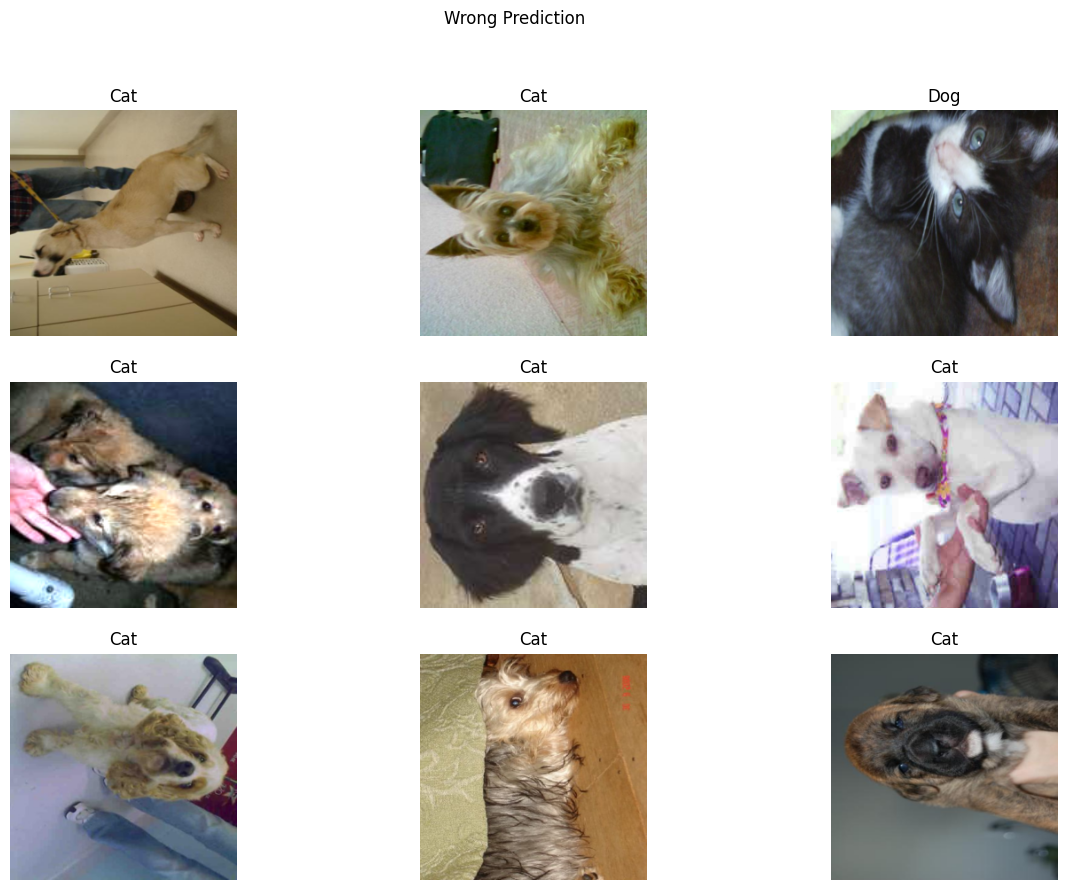

In [151]:
with torch.no_grad():
  for img, label in traindataloader:
    img = img.to(device)
    predictions = model(img)
    predictions = torch.sigmoid(predictions)
    predictions = np.where(predictions.cpu().numpy() > 0.5, 1, 0)
    idx = ((label == predictions.ravel()) == False).nonzero().squeeze()
    samples = random.sample(list(idx), k=9)

    fig, ax = plt.subplots(3,3, figsize=(15,10))
    ax = ax.ravel()

    for i in range(9):
      ax[i].imshow(img[samples[i]].T.cpu())
      ax[i].set_title(['Dog' if label[samples[i]] == 0 else 'Cat'][0])
      ax[i].axis('off')

    plt.suptitle('Wrong Prediction')
    plt.show()

    break